# Introduction

Those exercises will deal with the **Multiple Access Channel**

They will be splitted in three parts:

1. Basic Reinforcement Learning
2. Reinforcement Learning with Q-Learning
3. Deep Reinforcement Learning with a Deep Q-Network

In each part, the goal will be to **find the best channel out of 7 possible channels**.

# Initialization

Import and initialize everyting that is needed

**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

In [19]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

If you selected the GPU hardware acceleration, you should at least see one GPU available :

In [20]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
from tensorflow.keras.layers import Dense

print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.0.0
Number of GPUs available : 0


In [21]:
import os
import copy
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

In [22]:
# Configure the view in Jupyter Notebook
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 100%; }
    div#maintoolbar-container { width: 100%; }
</style>
"""))

In [23]:
SEED = 1

# Create environment variables

**You should not look at the cell below. It describes the network we want to transmit in.**

**Don't touch it !**

In [24]:
def new_grid(random=False, nb_ch=7, nb_states=5, min_nb=1, max_nb=3, display=False):
    
    if random == False :
        grid = np.array([[1, 1, 1, 1, 0],
                         [0, 1, 0, 0, 0],
                         [0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0],
                         [1, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0],
                         [0, 0, 0, 1, 1]])
    else:
        poss_ch = []
        nb_good_ch = np.random.randint(min_nb, max_nb)
        poss_ch.append(np.sort(np.random.choice(np.arange(nb_ch), size=(nb_good_ch), replace=False)))

        for i in range(nb_states-1):
            new = 0
            while new == 0:
                nb_good_ch = np.random.randint(min_nb, max_nb)
                new_ch = np.sort(np.random.choice(np.arange(nb_ch), size=(nb_good_ch), replace=False))
                for i in range(len(poss_ch)):
                    if np.array_equal(poss_ch[i], new_ch):
                        new-=1
                if new < 0:
                    new = 0
                else:
                    new = 1

            poss_ch.append(new_ch)

        grid = np.zeros((nb_ch, nb_states))

        for i in range(nb_states):
            for j in range(poss_ch[i].shape[0]):
                grid[poss_ch[i][j], i] = 1
                
    if display == True:
        plt.imshow(grid, cmap='gray', vmin=0, vmax=1)
        plt.xticks(np.arange(0, grid.shape[1]))
        
    return grid.astype(np.float32)
    

# 1. Online Training - Multi armed bandit

**Don't look at the code below. It's the code of the environment.**

In [25]:
# DO NOT LOOK AT THAT CODE
class ChooseEnv():
    def __init__(self):
        self.ch_grid = new_grid()
        
        self.state = 0
        print('This environment has 7 different channels')
        
    def run(self, choice):
        
        reward = self.ch_grid[choice, self.state]
        
        self.state  = (self.state + 1)%5
        
        return(reward)
        

### Problem formulation:
- You have a Wi-Fi network with 7 different channels
- You need to transmit 10.000 packets

--> Which channel do you choose?

### Framework:
- For each attempt, you choose a channel (action)
- If the packet was sent, you got a reward  : 1
- If there was a collision, you got no reward  : 0

**GOAL : Online training $\rightarrow$ Find the best action to maximize the total number of transmitted packets (received rewards)**

First, we need to instantiate an environment, that we call `choose_env` :

In [26]:
choose_env = ChooseEnv()

This environment has 7 different channels


This environment takes as input the action (chosen channel) and outputs a reward

The action needs to be an integers between 0 and 6

To call the environment, just use `reward = choose_env.run(action)`

## $\epsilon$-greedy agents

It's time to build our $\epsilon$-greedy agent

It needs to keep track of :
- The number of channels availables (7 here)
- Its $\epsilon$-value 
- The number of times it accessed each channels $N_t(a)$
- The estimated q_values for each channels
- The cumulative reward (optional)

The q_values are stored in a array and initialized at zeros : $[q_0, q_1, ..., q_6]$ (7 channels)

Same for the number of channel access

In [34]:
class GreedyAgent():
    def __init__(self, nb_channels, epsilon):
        
        self.nb_channels = nb_channels
        self.epsilon = epsilon
        
        self.nb_ch_access = np.zeros(shape=(self.nb_channels))
        self.q_values = np.zeros(shape=(self.nb_channels))
        
        
        self.cumulative_reward = 0
    
    def choose_action(self):
        # First time ?
        if np.all(self.q_values == 0):
            self.choice = np.random.randint(low=0, high = self.nb_channels)
        
        # Explore ?
        elif np.random.uniform(size=1) < self.epsilon :
            self.choice = np.random.randint(low=0, high = self.nb_channels)
        
        # Choose the action that has the best q-value
        else:
            self.choice = np.argmax(self.q_values)
        
        return self.choice
            
    def update_q_value(self, reward):
        
        #Update the q_values
        self.nb_ch_access[self.choice] += 1
        self.q_values[self.choice] += (reward - self.q_values[self.choice])/self.nb_ch_access[self.choice]
        
        #Update the cumulative reward
        self.cumulative_reward += reward
        
    def get_cum_reward(self):
        return self.cumulative_reward
    
    def get_q_values(self):
        return self.q_values

To see the effect of the exploration parameter $\epsilon$, we evaluate 11 agents with $\epsilon$ ranging from 0 to 1.

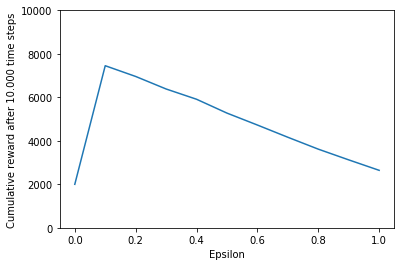

In [35]:
greedy_results = []

#Number of packets we send
len_test = 10000

#Range of epsilons we want to test
epsilon_range = np.linspace(0, 1, 11)
for eps in epsilon_range :
    
    #Set the same seed for each agent
    np.random.seed(SEED)
    
    #create an agent with a given epsilon value
    agent_g = GreedyAgent(nb_channels = 7, epsilon = eps)

    #Send 10.000 packets
    for i in range(len_test):
        action = agent_g.choose_action()
        reward = choose_env.run(action)
        agent_g.update_q_value(reward)
    
    #Store cumulative reward for that agent
    greedy_results.append(agent_g.get_cum_reward())

# Plot the cumulative reward as a function of the epsilon value
plt.plot(epsilon_range, greedy_results)
plt.ylim(0, len_test)
plt.xlabel('Epsilon')
plt.ylabel('Cumulative reward after 10.000 time steps');

What was the best epsilon?

In [36]:
best_epsilon = epsilon_range[np.argmax(greedy_results)]
print('Best epsilon = ' + str(best_epsilon))

Best epsilon = 0.1


We can see wich channels where choosen for different epsilon values to understand the result :

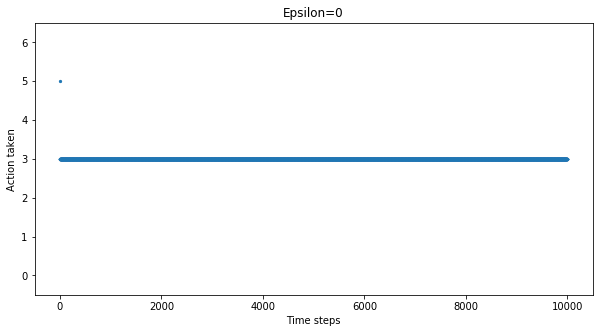

Q values after 10.000 times steps: 
[0.  0.  0.  0.2 0.  0.  0. ]


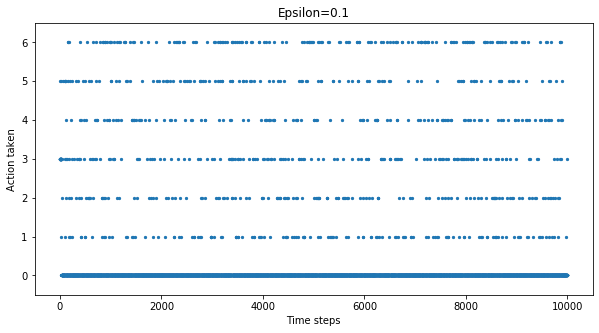

Q values after 10.000 times steps: 
[0.8  0.16 0.   0.14 0.21 0.   0.4 ]


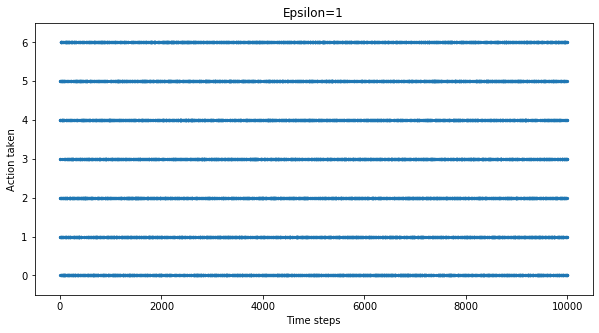

Q values after 10.000 times steps: 
[0.8  0.2  0.   0.2  0.21 0.   0.4 ]


In [39]:
regret_dic = {}

for eps in [0, best_epsilon, 1]:
    
    regret_dic[str(eps)]=[]
    
    action_history=[]

    np.random.seed(SEED)
    agent_g = GreedyAgent(nb_channels = 7, epsilon = eps)

    for i in range(len_test):
        action = agent_g.choose_action()
        reward = choose_env.run(action)
        agent_g.update_q_value(reward)
        
        #Record logs
        action_history.append(action)
        regret_dic[str(eps)].append(agent_g.get_cum_reward())
    
    # Display the actions
    plt.figure(figsize=(10, 5))
    plt.title(('Epsilon='+str(eps)))
    plt.ylabel('Action taken')
    plt.ylim(-0.5, 6.5)
    plt.xlabel('Time steps')
    plt.scatter(np.arange(len_test), action_history, s=5)
    plt.show()
    print('Q values after 10.000 times steps: \n'+np.array2string(agent_g.get_q_values(), precision=2))

We can see that :

- For $\epsilon=0$, the agent does not explore at all. It finds a channel where there is some rewards and stay on it (even if it is not the best one)
- For $\epsilon=0.1$, the agent strikes the right balance between exploration and exploitation. It test all channels multiple times but mostly stay on the 0th one since it is the best one
- For $\epsilon=1$, the agent only explores randomly every time.

## Upper Confidence Bound Agent

Now, we build a better agent that implements the Upper Confidence Bound policy

It needs to keeps track of:
- The number of channels availables (7 here)
- The number of times it accessed each channels $N_t(a)$
- The estimated q_values for each channels
- The UCB for each channel $ = Q_t(a) + \sqrt(\frac{ln(t)}{N_t(a)})$
- The cumulative reward (optional)

The ucb values are stored in a array and initialized at zeros : $[ucb_0, ucb_1, ..., ucb_6]$ (7 channels)


In [40]:
class UCBAgent():
    def __init__(self, nb_channels):
        
        self.nb_channels = nb_channels
        self.nb_ch_access = np.zeros(shape=(self.nb_channels))
        self.q_values = np.zeros(shape=(self.nb_channels))
        
        self.ucb = np.zeros(shape=(self.nb_channels))
        self.cumulative_reward = 0
        self.time_step = 0
    
    def choose_action(self):
        
        # First time ?
        if self.time_step < self.nb_channels:
            self.choice = self.time_step
        
        else:
            self.choice = np.argmax(self.ucb)
        
        return self.choice
            
    def update_q_value(self, reward):
        
        #Update the UCB values
        self.time_step += 1 
        self.nb_ch_access[self.choice] += 1
        self.q_values[self.choice] += (reward - self.q_values[self.choice])/self.nb_ch_access[self.choice]
        self.ucb[self.choice] = self.q_values[self.choice] + np.sqrt(2*np.log(self.time_step)/self.nb_ch_access[self.choice])
        
        #Update the cumulative reward
        self.cumulative_reward += reward
        
    def get_cum_reward(self):
        return self.cumulative_reward
    
    def get_q_values(self):
        return self.q_values

Let's play with that UCB agent :

In [41]:
action_history=[]
regret_dic['ucb']=[]

#Instantiate the agent
np.random.seed(SEED)
agent_ucb = UCBAgent(nb_channels = 7)

#Send 10.000 packets
for i in range(len_test):
    action = agent_ucb.choose_action()
    reward = choose_env.run(action)
    agent_ucb.update_q_value(reward)
    
    #Record logs
    action_history.append(action)
    regret_dic['ucb'].append(agent_ucb.get_cum_reward())

Q values after 10.000 times steps: 
[0.8  0.19 0.   0.17 0.24 0.   0.27]


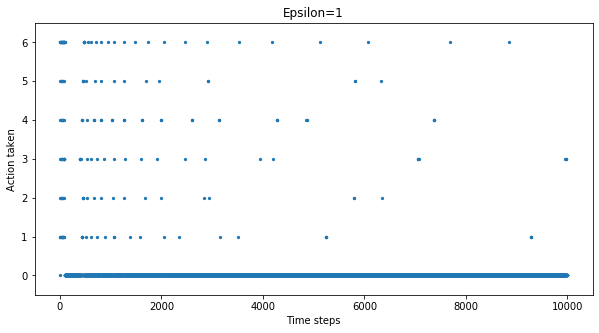

In [42]:
plt.figure(figsize=(10, 5))
plt.title(('Epsilon='+str(eps)))
plt.ylabel('Action taken')
plt.ylim(-0.5, 6.5)
plt.xlabel('Time steps')
plt.scatter(np.arange(len_test), action_history, s=5)
print('Q values after 10.000 times steps: \n'+np.array2string(agent_ucb.get_q_values(), precision=2))

We can see that the agent became more and more confident that the channel 0 was the best one, hence it took the others less and less.

**Now, let's compare all agents :**

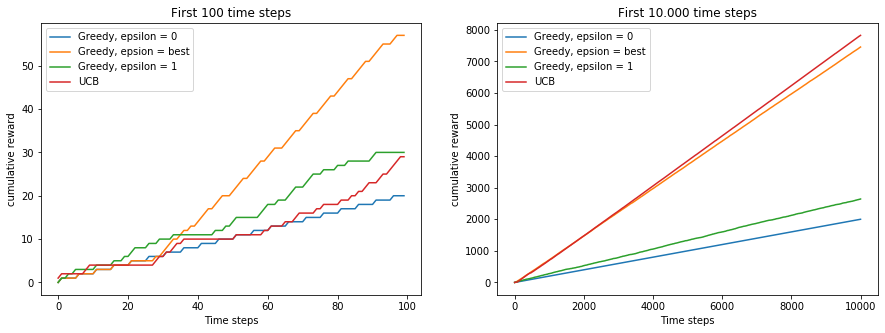

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('First 100 time steps')
plt.xlabel('Time steps')
plt.ylabel('cumulative reward')
plt.plot(np.arange(100), regret_dic['0'][:100], label='Greedy, epsilon = 0')
plt.plot(np.arange(100), regret_dic[str(best_epsilon)][:100], label='Greedy, epsion = best')
plt.plot(np.arange(100), regret_dic['1'][:100], label ='Greedy, epsilon = 1')
plt.plot(np.arange(100), regret_dic['ucb'][:100], label='UCB')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('First 10.000 time steps')
plt.xlabel('Time steps')
plt.ylabel('cumulative reward')
plt.plot(np.arange(len_test), regret_dic['0'], label='Greedy, epsilon = 0')
plt.plot(np.arange(len_test), regret_dic[str(best_epsilon)], label='Greedy, epsion = best')
plt.plot(np.arange(len_test), regret_dic['1'], label ='Greedy, epsilon = 1')
plt.plot(np.arange(len_test), regret_dic['ucb'], label='UCB')
plt.legend();


We can see that the UCB agent was pretty bad during the first 100 time steps (left figure), but better overall (right figure)

# 2. Offline Training

## Standard Q-Learning

**Don't look at the code below. It's the code of the environment.**

In [17]:
# DO NOT LOOK AT THAT CODE
class SenseEnv():
    def __init__(self):
        
        self.ch_grid = np.array([[1, 1, 1, 1, 0],
                                 [0, 1, 0, 0, 0],
                                 [0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0],
                                 [1, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0],
                                 [0, 0, 0, 1, 1]]).astype(np.float32)
        self.init_state = [3, 4, 0]
        
        self.ch_state = self.init_state[1]
        self.curr_ch = self.init_state[0]
        
        print('This environment has 7 different channels')
        
    def run(self, action):
                
        self.ch_state  = (self.ch_state + 1)%5
        self.curr_ch = (self.curr_ch + action)%7
        
        reward = self.ch_grid[self.curr_ch, self.ch_state]
        
        if self.ch_state == 4 :
            end = 1
        else :
            end = 0
        
        return(reward, [self.curr_ch, self.ch_state, end])
    
    def get_init_state(self):
        return self.init_state
    
    def initialize(self):
        self.ch_state = self.init_state[1]
        self.curr_ch = self.init_state[0]

**Don't look at the code below. It's boring.**

In [19]:
def evaluate_q_agent(agent, display = False):

    action_history=[]
    tot_reward = 0
    
    sense_env.initialize()
    first_state = sense_env.get_init_state()
    action = agent.choose_action(first_state, epsilon = 0)
    action_history.append(action)
    reward, new_state = sense_env.run(action)
    tot_reward += reward
    
    while new_state[2]==0:
        
        action = agent.choose_action(new_state, epsilon = 0)
        action_history.append(action)
        reward, new_state = sense_env.run(action)
        tot_reward += reward
    
    choosen_channels = [3]
    for i in range(len(action_history)):
        choosen_channels.append((choosen_channels[i]+action_history[i])%7)
    choosen_channels = choosen_channels[1:]

    if display == True :
        channels = np.array([[1, 1, 1, 1, 0],
                             [0, 1, 0, 0, 0],
                             [0, 0, 0, 0, 0],
                             [0, 1, 0, 0, 0],
                             [1, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0],
                             [0, 0, 0, 1, 1]]).astype(np.float32)
        plt.imshow(channels, cmap='gray', vmin=0, vmax=1)
        for i in range(len(choosen_channels)):
            plt.scatter(i, choosen_channels[i], color='r')
        print(str(tot_reward)[0]+'/5 packets have been transmitted')
    return tot_reward

### Problem formulation:

- You are in an industrial environment with 7 different channels
- All existing machines transmit with a certain periodicity
- You install a new IoT sensor, and need to find on which channel to transmit 5 packets
- You can sense the channels before sending a packet(!)

$\rightarrow$ Which channels do you choose?


### Framework: 
At each time step:
- You sense the channels (state)
- You see if the previously transmitted packet has been correctly received (reward)
- You decide on which channel you transmit next (action)

**Offline training** : You can learn on as many episodes as you want 


First, we need to instantiate an environment, that we call `sense_env` :

In [18]:
sense_env = SenseEnv()

This environment has 7 different channels


It's time to build our q-learning agent

It needs to keep track of :
- The number of channels availables (7 here)
- The number of times it accessed each channels $N_t(a)$
- The estimated q_values for each channels
- The cumulative reward (optional)

The q_values are stored in a array and initialized at zeros : $[q_0, q_1, ..., q_6]$ (7 channels)

Same for the number of channel access

In [20]:
class QAgent():
    def __init__(self, nb_channels, nb_ch_states, learning_rate, gamma):
        
        self.nb_channels = nb_channels
        self.nb_ch_states = nb_ch_states
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        self.q_values = np.zeros(shape=(self.nb_channels, self.nb_ch_states, 3))
        
        self.state = 0
        self.cumulative_reward = 0
    
    def choose_action(self, state, epsilon):
        
        self.curr_ch, self.ch_state, self.end = state
        
        # First time on that state ?
        if np.all(self.q_values[tuple([self.curr_ch, self.ch_state])] == 0):
            self.action = np.random.randint(low = -1, high = 2)
            
        # All actions equivalents
        elif np.all(self.q_values[tuple([self.curr_ch, self.ch_state])] == self.q_values[tuple([self.curr_ch, self.ch_state])][0]):
            self.action = np.random.randint(low = -1, high = 2)
            
        # Explore ?
        elif np.random.uniform(size=1) < epsilon :
            
            self.action = np.random.randint(low = -1, high = 2)
            
        else:
            self.action = np.argmax(self.q_values[tuple([self.curr_ch, self.ch_state])])-1

        return self.action
            
    def update_q_value(self, reward, new_state):
        
        n_curr_ch, n_ch_state, n_end = new_state
        
        q_value_index = [self.curr_ch, self.ch_state, self.action+1]
        self.q_values[tuple(q_value_index)] += self.learning_rate \
                        * (reward + (1-n_end) * self.gamma * np.max(self.q_values[tuple([n_curr_ch, n_ch_state])]) - self.q_values[tuple(q_value_index)])
        self.cumulative_reward += reward

        
    def step(self, reward, new_state, epsilon):
        
        self.update_q_value(reward, new_state)
        return self.choose_action(new_state, epsilon)
        
    def get_cum_reward(self):
        return self.cumulative_reward
    
    def get_q_values(self):
        return self.q_values
    
    def softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        return np.exp(x) / np.sum(np.exp(x), axis=0)

2/5 packets have been transmitted


2.0

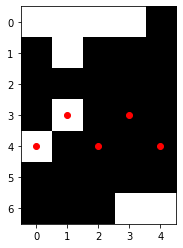

In [21]:
agent_q = QAgent(nb_channels=7, nb_ch_states=5, learning_rate=0.1, gamma=0)

np.random.seed(SEED)
nb_trainings = 10000

epsilon = 0.75

for i in range(nb_trainings):
    sense_env.initialize()
    first_state = sense_env.get_init_state()
    action = agent_q.choose_action(first_state, epsilon)
    reward, new_state = sense_env.run(action)
    
    while new_state[2] == 0:
        action = agent_q.step(reward, new_state, epsilon)
        reward, new_state = sense_env.run(action)
    agent_q.update_q_value(reward, new_state)

evaluate_q_agent(agent_q, display=True)

3/5 packets have been transmitted


3.0

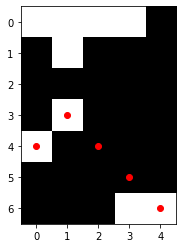

In [22]:
agent_q = QAgent(nb_channels=7, nb_ch_states=5, learning_rate=0.1, gamma=0.5)

np.random.seed(SEED)
nb_trainings = 10000

epsilon = 0.75

for i in range(nb_trainings):
    sense_env.initialize()
    first_state = sense_env.get_init_state()
    action = agent_q.choose_action(first_state, epsilon)
    reward, new_state = sense_env.run(action)
    
    while new_state[2] == 0:
        action = agent_q.step(reward, new_state, epsilon)
        reward, new_state = sense_env.run(action)
    agent_q.update_q_value(reward, new_state)

evaluate_q_agent(agent_q, display=True)

4/5 packets have been transmitted


4.0

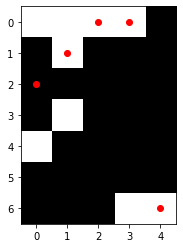

In [23]:
agent_q = QAgent(nb_channels=7, nb_ch_states=5, learning_rate=0.1, gamma=1)

np.random.seed(SEED)
nb_trainings = 10000

epsilon = 0.75

for i in range(nb_trainings):
    sense_env.initialize()
    first_state = sense_env.get_init_state()
    action = agent_q.choose_action(first_state, epsilon)
    reward, new_state = sense_env.run(action)
    
    while new_state[2] == 0:
        action = agent_q.step(reward, new_state, epsilon)
        reward, new_state = sense_env.run(action)
    agent_q.update_q_value(reward, new_state)

evaluate_q_agent(agent_q, display=True)

In [24]:
np.transpose(agent_q.q_values, [0, 2, 1])

array([[[0.        , 0.        , 2.        , 1.        , 0.        ],
        [0.        , 0.        , 2.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 3.        , 2.        , 0.        , 0.        ],
        [0.        , 2.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[4.        , 2.        , 0.        , 0.        , 0.        ],
        [2.        , 0.        , 0.        , 0.        , 0.        ],
        [2.        , 0.        , 0.        , 0.        , 0.        ]],

       [[2.        , 0.        , 0.        , 0.        , 4.        ],
        [2.        , 0.        , 0.        , 0.        , 2.        ],
        [2.        , 1.        , 0.        , 0.        , 3.        ]],

       [[2.        , 0.        , 0.        , 0.        , 0.        ],
        [2.        , 1.        , 0.        , 0.        , 0.        ],
        [2. 

# 3. Deep Q-Learning

In [25]:
# DO NOT LOOK AT THAT CODE
class DQEnv():
    def __init__(self, nb_channels = 7, nb_states=5, random=False):
        
        if (nb_channels+1)%2!=0:
            print('/!\ Please enter an even number of channels')
            
        self.nb_ch = nb_channels
        self.nb_states = nb_states
        
        self.grid = new_grid(random, self.nb_ch, self.nb_states, 1, int((self.nb_ch+1)/2), display=True)
        
        self.init_state = [int((self.nb_ch-1)/2), int(self.nb_states-1)]
        self.ch_state = self.init_state[1]
        self.curr_ch = self.init_state[0]
        self.sent_mess = 0
        
        print('This environment has ' + str(self.nb_ch) +' different channels')
        
    def run(self, action):
        
        self.sent_mess += 1
        
        self.ch_state  = (self.ch_state + 1)%self.nb_states
        
        self.curr_ch = (self.curr_ch + action)%self.nb_ch
        
        reward = self.grid[self.curr_ch, self.ch_state]
        
        if self.sent_mess != self.nb_states: 
            end = 0
        else :
            end = 1
        
        return(reward, [self.one_hot(self.curr_ch, self.nb_ch), self.grid[:, self.ch_state], end])
    
    def get_init_state(self):
        return [self.one_hot(self.init_state[0], self.nb_ch), self.grid[:, self.init_state[1]], 0]
    
    def initialize(self):
        self.ch_state = self.init_state[1]
        self.curr_ch = self.init_state[0]
        self.sent_mess = 0
        
    def one_hot(self, index, depth):
        oh = np.zeros(depth, dtype=np.float32)
        oh[index] = 1
        return oh

This environment has 7 different channels


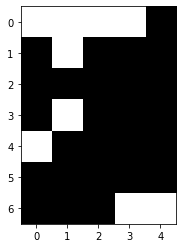

In [63]:
dq_env = DQEnv(random=False)

In [72]:
def evaluate_dq_agent(agent, grid, display = False):

    action_history=[]
    tot_reward = 0
    
    dq_env.initialize()
    first_state = dq_env.get_init_state()
    action = agent.choose_action(first_state, epsilon = 0)
    action_history.append(action)
    reward, new_state = dq_env.run(action)
    tot_reward += reward
    
    for j in range(grid.shape[1]-1):
        state = new_state
        action = agent.choose_action(state, epsilon = 0)
        action_history.append(action)
        reward, new_state = dq_env.run(action)
        tot_reward += reward

    choosen_channels = [(grid.shape[0]-1)/2]
    for i in range(len(action_history)):
        choosen_channels.append((choosen_channels[i]+action_history[i])%grid.shape[0])
    choosen_channels = choosen_channels[1:]

    if display == True :
        plt.imshow(grid, cmap='gray', vmin=0, vmax=1)
        for i in range(len(choosen_channels)):
            plt.scatter(i, choosen_channels[i], color='r')
        print(str(int(tot_reward))+'/'+str(grid.shape[1])+' packets have been transmitted')
    return tot_reward

In [65]:
class DQAgent():
    def __init__(self, nb_channels, learning_rate, gamma):
        
        self.nb_ch = nb_channels
        self.nb_actions = 3
        self.gamma = gamma
                        
        self.DQN_offline = tf.keras.models.Sequential([
            Dense(2*self.nb_ch, activation='relu'),
            Dense(self.nb_actions, activation='softplus')
        ])
        self.DQN_offline.build(input_shape=(None, self.nb_ch*2))
        
        self.DQN_online = tf.keras.models.Sequential([
            Dense(2*self.nb_ch, activation='relu'),
            Dense(self.nb_actions, activation='softplus')
        ])
        self.DQN_online.build(input_shape=(None, self.nb_ch*2))
        
        self.copy_parameters()
        
        self.loss_func = tf.keras.losses.MSE
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        
        self.history_length = 1000
        self.history = [[]for i in range(self.history_length)]
        self.history_idx = 0
        
    def choose_action(self, state, epsilon):
        
        # Explore ?
        if np.random.uniform(size=1) < epsilon :
            action =  np.random.randint(low = -1, high = 2)
        
        else:    
            curr_ch, ch_state, end = state
            DQN_input = tf.concat([curr_ch, ch_state], axis=0)[tf.newaxis, :]
            outputs = self.DQN_online(DQN_input).numpy()
            action = np.argmax(outputs)-1
            
        return action
    
    def learn(self, batch_size):
        
        idx = np.random.choice(range(self.history_length), batch_size, replace=False)
        rdm_exp =  [self.history[i] for i in idx]
        batch = [np.stack([rdm_exp[i][j] for i in range(batch_size)], axis=0) for j in range(5)]
        
        states_flt, actions, rewards, n_states_flt, end = batch
        
        max_n_q_values = tf.reduce_max(self.DQN_online(n_states_flt), axis=1).numpy()

        with tf.GradientTape() as tape:
            q_values = self.DQN_online(states_flt)
            target = q_values.numpy()
            target[np.arange(target.shape[0]), actions+1]= rewards + (1-end) * self.gamma * max_n_q_values
            self.loss = self.loss_func(q_values, target)

        gradients = tape.gradient(self.loss, self.DQN_online.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.DQN_online.trainable_weights))  
    
    def insert_history(self, state, action, reward, n_state):
        
        curr_ch, ch_state, end = state
        state_flt = np.concatenate([curr_ch, ch_state], axis=0)
        
        n_curr_ch, n_ch_state, n_end = n_state
        n_state_flt = np.concatenate([n_curr_ch, n_ch_state], axis=0)

        self.history[self.history_idx] = [state_flt, action, reward, n_state_flt, n_end]
        self.history_idx = (self.history_idx+1)%self.history_length
    
    def copy_parameters(self):
    
        weights = self.DQN_online.get_weights()
        self.DQN_offline.set_weights(weights)


In [66]:
tf.random.set_seed(SEED)
agent_dq = DQAgent(nb_channels=7, learning_rate=0.01, gamma=1)

In [67]:
np.random.seed(SEED)

epsilon = 1

# Build a first history
for i in range(200):
    dq_env.initialize()
    state = dq_env.get_init_state()
    action = agent_dq.choose_action(state, epsilon)
    reward, new_state = dq_env.run(action)
    agent_dq.insert_history(state, action, reward, new_state)
    while new_state[2]==0 :
        state = new_state
        action = agent_dq.choose_action(state, epsilon)
        reward, new_state = dq_env.run(action)
        agent_dq.insert_history(state, action, reward, new_state)  

In [68]:
np.random.seed(SEED)
nb_trainings = 250
loss = []    
epsilon = 0.75

for i in range(nb_trainings):
    dq_env.initialize()
    state = dq_env.get_init_state()
    action = agent_dq.choose_action(state, epsilon)
    reward, new_state = dq_env.run(action)
    agent_dq.insert_history(state, action, reward, new_state)
    agent_dq.learn(10)
    
    while new_state[2]==0 :
        state = new_state
        action = agent_dq.choose_action(state, epsilon)
        reward, new_state = dq_env.run(action)
        agent_dq.insert_history(state, action, reward, new_state) 
        agent_dq.learn(10)
    loss.append(tf.reduce_mean(agent_dq.loss).numpy())
    
    if (i+1)%10 == 0:
        agent_dq.copy_parameters()
        print((i+1), end=', ')

10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 

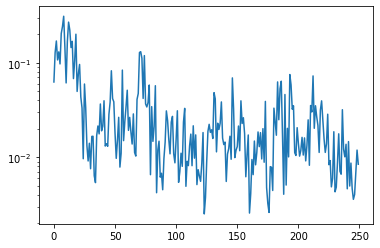

In [69]:
plt.semilogy(np.arange(len(loss)), loss)

4/5 packets have been transmitted


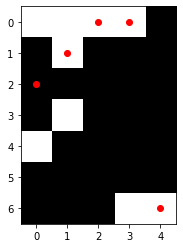

In [73]:
evaluate_dq_agent(agent_dq, dq_env.grid, display=True);

In [74]:
input_ = tf.convert_to_tensor(np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]))
agent_dq.DQN_online(input_)

<tf.Tensor: id=326039, shape=(1, 3), dtype=float32, numpy=array([[4.1901627, 1.9793606, 3.0142121]], dtype=float32)>

This environment has 9 different channels


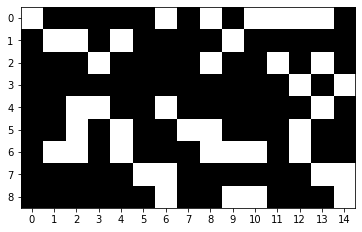

In [75]:
dq_env = DQEnv(nb_channels=9, nb_states=15, random=True)

In [76]:
tf.random.set_seed(SEED)
agent_dq = DQAgent(nb_channels=9, learning_rate=0.01, gamma=1)

In [77]:
np.random.seed(SEED)

epsilon = 1

# Build a first history
for i in range(200):
    dq_env.initialize()
    state = dq_env.get_init_state()
    action = agent_dq.choose_action(state, epsilon)
    reward, new_state = dq_env.run(action)
    agent_dq.insert_history(state, action, reward, new_state)
    while new_state[2]==0 :
        state = new_state
        action = agent_dq.choose_action(state, epsilon)
        reward, new_state = dq_env.run(action)
        agent_dq.insert_history(state, action, reward, new_state)  

In [78]:
np.random.seed(SEED)
nb_trainings = 500
loss = []    
epsilon = 0.5

for i in range(nb_trainings):
    dq_env.initialize()
    state = dq_env.get_init_state()
    action = agent_dq.choose_action(state, epsilon)
    reward, new_state = dq_env.run(action)
    agent_dq.insert_history(state, action, reward, new_state)
    agent_dq.learn(10)
    
    while new_state[2]==0 :
        state = new_state
        action = agent_dq.choose_action(state, epsilon)
        reward, new_state = dq_env.run(action)
        agent_dq.insert_history(state, action, reward, new_state) 
        agent_dq.learn(10)
    loss.append(tf.reduce_mean(agent_dq.loss).numpy())
    
    if (i+1)%50 == 0:
        agent_dq.copy_parameters()
        print((i+1), end=', ')

50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 

10/15 packets have been transmitted


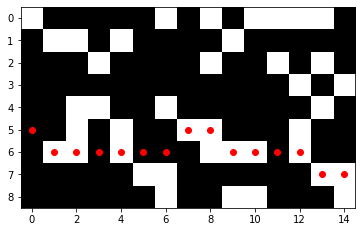

In [79]:
evaluate_dq_agent(agent_dq, dq_env.grid, display=True);